
## Klasifikasi Tahapan Tidur (Sleep Stage) dengan Data Polysomnography (PSG)

Pada kasus ini, kita akan mencoba melakukan klasifikasi tahapan tidur dengan menggunakan data PSD. Secara umum terdapat 2 tahapan tidur, pertama adalah ***rapid eye movement (REM)*** dan ***non-rapid eye movement (NREM)***. NREM dibagi lagi menjadi 4 tahapan tidur, yaitu *stage 1 (S1)*, *stage 2 (S2)*, *stage 3 (S3)*, dan *stage 4 (S4)*. Sehingga total keseluruhan tahapan proses manusia tidur adalah 6, yaitu, *awake (W)*, S1, S2, S3, S4, dan REM. Kita akan menggunakan 2 data PSG untuk mengklasifikasi 2 tahapan tidur, yaitu *awake (W)* dan *stage 1 (S1)*. Setiap label data akan di segmentasi dengan panjang segmen 60 detik. Pada kasus ini, fitur yang akan digunakan adalah *Power Spectral Density (PSD)* untuk selanjutnya akan diklasifikasikan dengan menggunakan algoritma *Support Vector Machine (SVM)* dengan kernel linier.

## Dataset

Dataset yang akan kita gunakan adalah dataset publik yang didapatkan dari Physionet yaitu [Sleep-EDF Database Expanded](https://www.physionet.org/content/sleep-edfx/1.0.0/). Dataset tersebut dapat diunduh langsung melalui lama Physionet atau dapat diunduh dengan menggunakan bantuan library seperti MNE. Pada kasus ini, kita akan menggunakan fungsi **mne.datasets** untuk mengunduh dataset tersebut. Pada dataset **Sleep-EDF Database Expanded** terdapat beberapa tambahan informasi yang disematkan didalam dataset sebagai label (anotasi). Anotasi ini merupakan informasi yang menujukkan kapan sebuah *event* terjadi pada saat proses perekaman berlangsung. Dikarenakan perekaman dilakukan tanpa berhenti, maka, fungsi anotasi ini sangat penting untuk mengetahui kapan terjadinya tahapan-tahapan tidur. Penganotasian ini dilakukan oleh para ahli selama proses perekaman data. Tabel dibawah ini menunjukkan anotasi yang digunakan pada dataset.

| Nama Anotasi | Keterangan |
| --- | --- |
Sleep stage W | Tahapan *awake*
Sleep stage R | Tahapan REM
Sleep stage 1 | Tahapan S1
Sleep stage 2 | Tahapan S2
Sleep stage 3 | Tahapan S3
Sleep stage 4 | Tahapan S4
Sleep stage ? | Tahapan tidak dikalkulasi

### Profil Subyek Dataset

Data dari 82 orang (laki-laiki dan perempuan) sebanyak 2 sesi perekaman terdapat didalam dataset. Total perekaman hampir 24 jam dengan sampling rate 100 Hz

### Bentuk Data Dataset

Dataset disimpan dalam 2 bentuk, yaitu

1. __SC*PSG.edf__ : Data utama yang memuat data sinyal EEG (Fpz-Cz, Pz-Oz), EOG (horizontal), _oro-nasal respiration_, _EMG submental_, _rectal body temperatur_, dan _event marker_
2. __*Hymnogram__ : Data anotasi _event_

<br>
<br>

---

In [31]:
# Import semua library yang dibutuhkan

# Kebutuhan proses matematis
import numpy as np
import matplotlib.pyplot as plt

# Kebutuhan download dataset, inspeksi sinyal EEG, dan ektraksi fitur
import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

# Kebutuhan klasifikasi
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

In [32]:
"""
Memuat dataset Sleep-EDF Dabaset Extended dari Physionet via MNE
Informasi lengkap tentang fungsi mne.datasets.sleep_physionet.age.fetch_data dapat dilihat di:
https://mne.tools/stable/generated/mne.datasets.sleep_physionet.age.fetch_data.html#mne.datasets.sleep_physionet.age.fetch_data

FYI: Proses download data akan memakai waktu yang cukup lama, tergantungdari koneksi internet. Data akan tersimpan pada folder “~/mne_data” secara default.
"""

A, B = 0, 3 # Subyek yang akan diambil adalah subyek ke-0 dan ke-3 dari dataset
[A_files, B_files] = fetch_data(subjects=[A, B], recording=[1]) # Mengambil path data subyek ke-0 dan ke-3 dari sesi perekaman ke-1

"""
Pada skenario yang kita lakukan, subyek A akan menjadi basis dari data training, sedangkan subyek B akan menjadi basis dari data testing.
"""

Using default location ~/mne_data for PHYSIONET_SLEEP...


'\nPada skenario yang kita lakukan, subyek A akan menjadi basis dari data training, sedangkan subyek B akan menjadi basis dari data testing.\n'

Extracting EDF parameters from /Users/afif/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


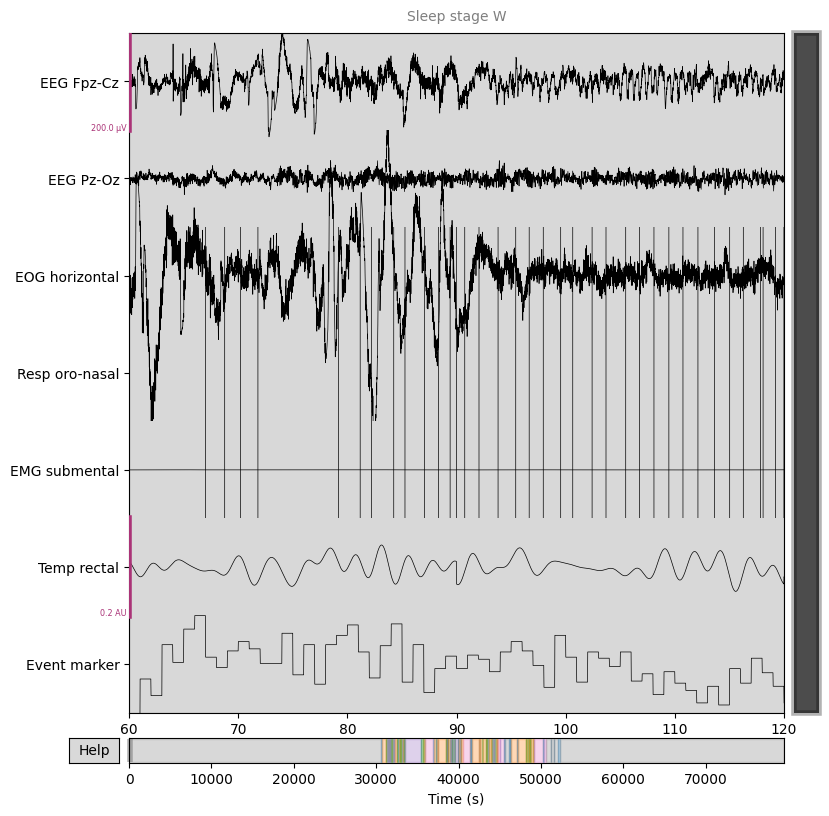

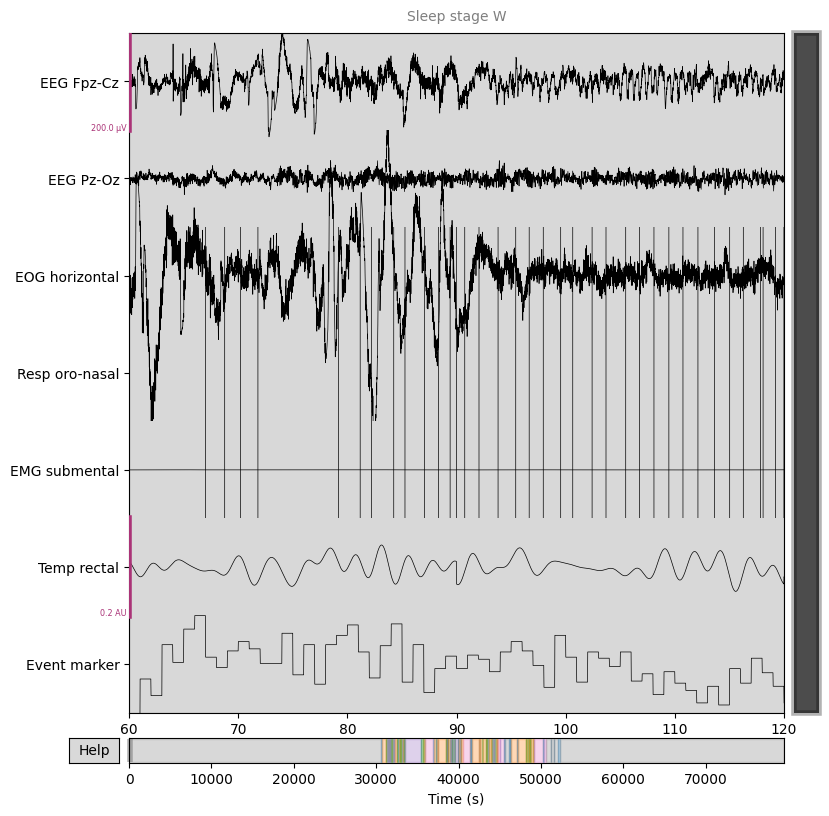

In [33]:
# Memuat data subyek A

# Memuat data EDF yang mengandung sinyal EEG
raw_train = mne.io.read_raw_edf(A_files[0], stim_channel='Event marker', misc=['Temp rectal'])

# Memuat data anotasi
annot_train = mne.read_annotations(A_files[1])

# Memasangkan data dengan anotasinya
raw_train.set_annotations(annot_train, emit_warning=False) # 

# Ploting data
# Scaling dilakukan untuk memperbaiki kualitas data dan visualisasi
# Satuan yang digunakan adalah volt
raw_train.plot(start=60, duration=60,
               scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
                             misc=1e-1))

In [34]:
# Check informasi data
raw_train.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG ...
 chs: 5 EEG, 1 misc, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1989-04-24 16:13:00 UTC
 nchan: 7
 projs: []
 sfreq: 100.0 Hz
>

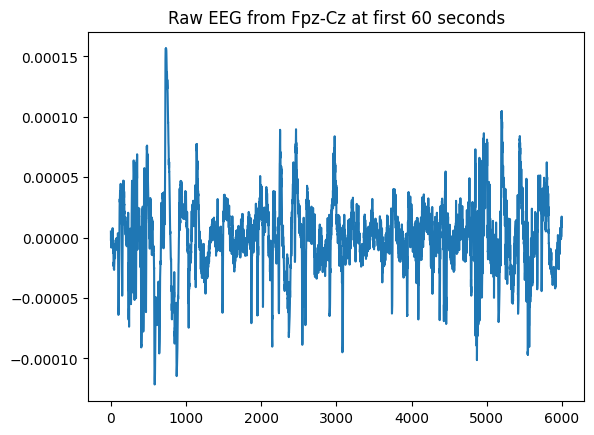

In [35]:
# Jika Anda tidak nyaman dengan bentuk obyek yang dihasilkan oleh mne.io.read_raw_edf, 
# Anda dapat mengubah data pada obyek tersebut menjadi DataFrame dengan fungsi get_data().

# Ubah data sinyal ke DataFrame
raw = raw_train.get_data()

# Plot data channel ke-0 (Fpz-Cz) selama 60 detik
plt.plot(raw[0, 0:60*100])
plt.title('Raw EEG from Fpz-Cz at first 60 seconds')
plt.show()

In [36]:
# Cek anotasi data
annot_train[0]

OrderedDict([('onset', 0.0),
             ('duration', 30630.0),
             ('description', 'Sleep stage W'),
             ('orig_time', None)])

In [37]:
# Cek anotasi data dalam bentuk DataFrame
annot_pd = annot_train.to_data_frame()
print(annot_pd)

# Cek jumlah anotasi untuk setiap tahapan tidur
print(annot_pd['description'].value_counts())

                  onset  duration    description
0   1970-01-01 00:00:00   30630.0  Sleep stage W
1   1970-01-01 08:30:30     120.0  Sleep stage 1
2   1970-01-01 08:32:30     390.0  Sleep stage 2
3   1970-01-01 08:39:00      30.0  Sleep stage 3
4   1970-01-01 08:39:30      30.0  Sleep stage 2
..                  ...       ...            ...
149 1970-01-01 14:19:00      30.0  Sleep stage 1
150 1970-01-01 14:19:30     540.0  Sleep stage W
151 1970-01-01 14:28:30     150.0  Sleep stage 1
152 1970-01-01 14:31:00   27240.0  Sleep stage W
153 1970-01-01 22:05:00    6900.0  Sleep stage ?

[154 rows x 3 columns]
Sleep stage 3    48
Sleep stage 2    40
Sleep stage 1    24
Sleep stage 4    23
Sleep stage W    12
Sleep stage R     6
Sleep stage ?     1
Name: description, dtype: int64


In [38]:
'''
Pada kasus yang akan kita selesaikan, kita hanya akan mengklasifikasikan 2 tahapan tidur, yaitu
awake (W) dan sleep stage 1 (S1). Oleh kena itu, kita perlu mendefinisikan, anotasi mana yang akan kita gunakan sebagai label
yang akan digunakan untuk training dan testing.
'''

# Mendefinisikan anotasi dan label
new_annot = {
    'Sleep stage W': 1,
    'Sleep stage 1': 2
}

# Memilih event yang akan digunakan (W dan S1)
# dengan fungsi mne.events_from_annotations berdasarkan parameter event_id
events_train, _ = mne.events_from_annotations(raw_train, event_id=new_annot, chunk_duration=60.)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage W']


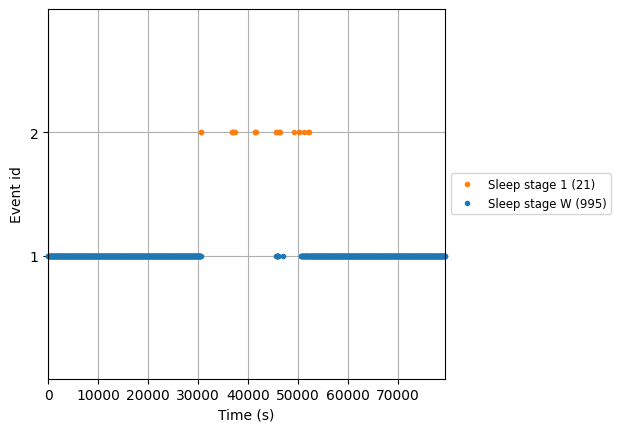

In [39]:
# plot event untuk mengetahui waktu kejadian dan jumlah event
fig = mne.viz.plot_events(events_train, event_id=new_annot,
                          sfreq=raw_train.info['sfreq'],
                          first_samp=events_train[0, 0])

# Pengaturan warna matplotlib
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [40]:
'''
Kita akan membagi sinyal, baik W dan S1 menjadi beberapa segmen, atau juga dikenal sebagai epoch.
Proses segmentasi lazim digunakan pada pengolahan sinyal EEG karena kita ingin mendapatkan informasi
pada setiap rentang waktu tertentu pada data yang kontinu.

Pada kasus ini, kita akan melakukan segmentasi sepanjang 60 detik.
Sehingga, data sinyal EEG akan disegmentasi setiap 60*100=6000 data poin.
'''

# Mendefinisikan panjang segmen jika tidak dapat tepat 6000 data point
tmax = 60. - 1. / raw_train.info['sfreq']  # tmax in included

# Membuat segmentasi / epoch
epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                          event_id=new_annot, tmin=0., tmax=tmax, baseline=None)

print(epochs_train)

Not setting metadata
1016 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1016 events (good & bad), 0 - 59.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage W': 995
 'Sleep stage 1': 21>


In [41]:
# Kita lakukan hal yang sama untuk Subyek B
# Subyek B akan kita gunakan sebagai data testing

# Membuat data EDF
raw_test = mne.io.read_raw_edf(B_files[0], stim_channel='Event marker',
                               misc=['Temp rectal'])

# Membuat data anotasi
annot_test = mne.read_annotations(B_files[1])

# Memasangkan data dengan anotasinya
raw_test.set_annotations(annot_test, emit_warning=False)

# Memilih hanya event W dan S1
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=new_annot, chunk_duration=60.)

# Membuat segmentasi / epoch
epochs_test = mne.Epochs(raw=raw_test, events=events_test, event_id=new_annot,
                         tmin=0., tmax=tmax, baseline=None)

print(epochs_test)

Extracting EDF parameters from /Users/afif/mne_data/physionet-sleep-data/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage W']
Not setting metadata
1020 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1020 events (good & bad), 0 - 59.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage W': 999
 'Sleep stage 1': 21>


In [42]:
def eeg_features(epochs):
    """Ekstraksi fitur EEG

    Fungsi ini akan menggunakan obyek `mne.Epochs` untuk membuat fitur setiap epoch
    dengan fitur Power Spectral Density (PSD).

    Parameters
    ------------
    epochs : MNE epochs
        The epochs data

    Returns
    X : numpy array of shape [n_samples, n_bands]
        The transformed data
    """

    # Mendefinisikan rentang band yang akan digunakan
    EEG_BANDS = {
        'delta': [0., 4.],
        'tetha': [4., 8.],
        'alpha': [8., 12.],
        'beta': [12., 22.],
        'gamma': [30., 45.]
    }

    # Pilih hanya kanal 'eeg' yang digunakan pada parameter picks
    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0., fmax=45.)
    
    # Normalisasi nilai PSD
    psds /= np.sum(psds, axis=-1, keepdims=True)

    # Ekstraksi fitur semua epoch
    # Disimpan dalam bentuk numpy ndarray (multimedinsional array)
    X = []
    for fmin, fmax in EEG_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [45]:
# Cek ekstraksi fitur
featues = eeg_features(epochs_train)

Loading data for 1016 events and 6000 original time points ...
Effective window size : 2.560 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s finished


In [46]:
# Cek data setiap epoch dan labelnya
epochs_train.events

array([[      0,       0,       1],
       [   6000,       0,       1],
       [  12000,       0,       1],
       ...,
       [7932000,       0,       1],
       [7938000,       0,       1],
       [7944000,       0,       1]])

In [47]:
'''
Langkah terakhir, kita akan melakukan proses klasifikasi.
Untuk memudahkan dan meringkas kode, kita akan membuat sebuah pipeline dengan menggunakan fungsi make_pipeline() dari sklearn.

Pipeline yang kita buat terdiri dari 2 proses

1. Ekstaksi fitur EEG dengan fungsi yang sudah kita definisikan, yaitu eeg_features()
2. Klasifiksi dengan menggunakan SVM dengan kernel linier
'''

# Membuat pipeline
pipeline = make_pipeline(FunctionTransformer(eeg_features, validate=False), SVC(kernel='linear'))

# Train
y_train = epochs_train.events[:, 2] # 2 adalah posisi label pada array.
pipeline.fit(epochs_train, y_train)

# Test
y_test = epochs_test.events[:, 2]
y_pred = pipeline.predict(epochs_test)

# Evaluasi model
acc = accuracy_score(y_test, y_pred)
print("Accuracy score: {}".format(acc))

Loading data for 1016 events and 6000 original time points ...
Effective window size : 2.560 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Loading data for 1020 events and 6000 original time points ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


0 bad epochs dropped
Effective window size : 2.560 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy score: 0.9794117647058823


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished
